In [1]:
import sys, os
import argparse
import numpy as np
import pandas as pd
import json
from random import sample
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)

sys.path.append(os.path.join(os.path.expanduser("~"),"resources/"))
from stats import statstools
from idp import idp
from sklearn.feature_extraction.text import CountVectorizer



promptsFile = "/data/language-model-toxicity/results/prompts/gpt2/prompts_n_50percent_gpt2.jsonl"
perspCols = ['insult', 'severe_toxicity', 'toxicity', 'profanity',
             'sexually_explicit', 'identity_attack', 'flirtation', 'threat']
contPerspCols = [f"cont_{c}" for c in perspCols]
promptPerspCols = [f"prompt_{c}" for c in perspCols]
genAvgPerspCols = [f"gens_{c}_avg" for c in perspCols]
genStdPerspCols = [f"gens_{c}_std" for c in perspCols]
genMaxPerspCols = [f"gens_{c}_max" for c in perspCols]
gen1qtPerspCols = [f"gens_{c}_1qt" for c in perspCols]
gen3qtPerspCols = [f"gens_{c}_3qt" for c in perspCols]
genMinPerspCols = [f"gens_{c}_min" for c in perspCols]
genMedPerspCols = [f"gens_{c}_med" for c in perspCols]
genPctGt50PerspCols = [f"gens_{c}_pctGt50" for c in perspCols]


## Data formatting

In [153]:
# data: json with 'filename', 'begin', 'end', 'prompt', 'continuation', 'generations'
# prompt, continuation: text + perspCols
# generations: list of text+perspCols
with open(promptsFile) as f:
    data = [json.loads(l) for i,l in tqdm(enumerate(f),desc="Loading file")]
print(len(data))
# data = list(sample(data,50000))


132174


In [154]:
# Aggregating data
def aggregateGenInfo(gens,c):
    gen_vals = [g[c] for g in gens if g[c] is not None and not pd.isnull(g[c])]
    if not len(gen_vals): return []
    out = list(zip(["min","1qt","med","3qt","max"],np.percentile(gen_vals,[0,25,50,75,100])))
    out.append(("std",np.std(gen_vals)))
    out.append(("avg",np.mean(gen_vals)))
    out.append(("pctGt50",np.mean([i>.5 for i in gen_vals])))
    return out

fData = []
for d in tqdm(data,desc="Aggregating"):
    newD = {c: d[c] for c in ['filename', 'begin', 'end']}
    for c in ["text"]+perspCols:
        newD["prompt_"+c] = d["prompt"][c]
        newD["cont_"+c] = d["continuation"][c]
        if c == "text": continue
        for k, v in aggregateGenInfo(d["generations"],c):
            newD["gens_"+c+"_"+k] = v
        
        # newD["gens_"+c+"_avg"] = 
            
    fData.append(newD)
df = pd.DataFrame(fData)
df.index.name = "id"
df.reset_index("id",inplace=True)

# Long generations dataframe
gensData = {(i,j): gd for i,d in tqdm(enumerate(data),desc="Generations") for j,gd in enumerate(d["generations"])}
longDf = pd.DataFrame.from_dict(gensData,orient="index")
longDf.index.names = "id","gen_id"
longDf.reset_index(inplace=True)

In [155]:
# Create subsets of prompts
df["toxicGens"] = (df["gens_toxicity_pctGt50"]>.1).astype(int)
print(df.toxicGens.value_counts(),"\n")

df["toxicCont"] = (df["cont_toxicity"] > .5).astype(int)
print(df.toxicCont.value_counts(),"\n")

toxicPromptDf = df.query("prompt_toxicity >.5").copy()
print(len(toxicPromptDf), len(toxicPromptDf) / len(df))
nonToxicPromptDf = df.query("prompt_toxicity <=.5").copy()
print(len(nonToxicPromptDf), len(nonToxicPromptDf) / len(df))

0    67253
1    64921
Name: toxicGens, dtype: int64 

1    95772
0    36402
Name: toxicCont, dtype: int64 

58958 0.44606352232663005
72731 0.5502670721927156


##  Basic stats

{'n': 131213, 'r': -0.7607231336077149, 'p': 0.0}


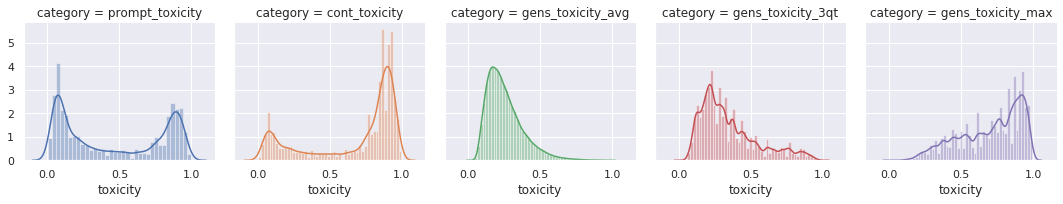

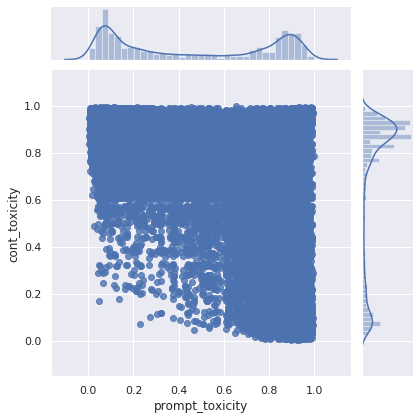

In [156]:
promptContToxicityDf = df.melt(id_vars="id",var_name="category",value_name="toxicity",
                               value_vars=['prompt_toxicity',"cont_toxicity","gens_toxicity_avg",
                                          "gens_toxicity_3qt","gens_toxicity_max"])
g = sns.FacetGrid(promptContToxicityDf, col="category",hue="category")
g.map(sns.distplot,"toxicity")

sns.jointplot(x="prompt_toxicity", y="cont_toxicity", data=df, kind="reg")
print(statstools.correlSummary(df,"prompt_toxicity","cont_toxicity"))

### Toxic prompts only (toxicity>.5)
Correlation between `pct toxic generations` and prompt/continuation toxicity.
The prompts and generation toxicity is somewhat correlated, but the continuation and generation less so.

{'n': 58865, 'r': 0.19405317492601462, 'p': 0.0}


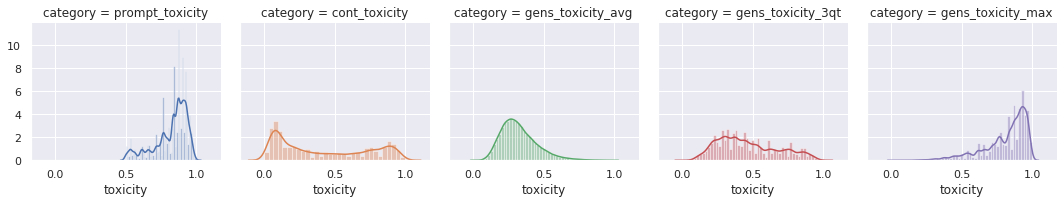

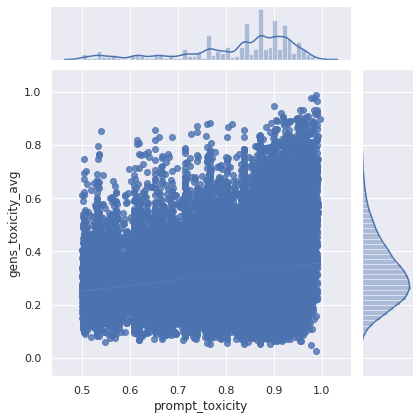

In [158]:
toxicPrompts = toxicPromptDf.melt(id_vars="id",var_name="category",value_name="toxicity",
                               value_vars=['prompt_toxicity',"cont_toxicity","gens_toxicity_avg",
                                          "gens_toxicity_3qt","gens_toxicity_max"])
g = sns.FacetGrid(toxicPrompts, col="category",hue="category")
g.map(sns.distplot,"toxicity")
sns.jointplot(x="prompt_toxicity", y="gens_toxicity_avg", data=toxicPromptDf, kind="reg")

print(statstools.correlSummary(toxicPromptDf,"prompt_toxicity","gens_toxicity_avg"))

In [160]:
print(statstools.correlSummaries(
    toxicPromptDf,"gens_toxicity_pctGt50",["prompt_toxicity","cont_toxicity"]).round(4))
print(statstools.correlSummaries(
    toxicPromptDf,"prompt_toxicity",["gens_toxicity_pctGt50","gens_toxicity_avg","gens_toxicity_3qt"]).round(4))

                       n       r    p  p_holm
prompt_toxicity  58865.0  0.2225  0.0     0.0
cont_toxicity    58551.0  0.1054  0.0     0.0
                             n       r    p  p_holm
gens_toxicity_pctGt50  58865.0  0.2225  0.0     0.0
gens_toxicity_avg      58865.0  0.1941  0.0     0.0
gens_toxicity_3qt      58865.0  0.2109  0.0     0.0


### Non-toxic prompts only (toxicity <= .5)
#### Data distributions

{'n': 72643, 'r': 0.3925153762499149, 'p': 0.0}


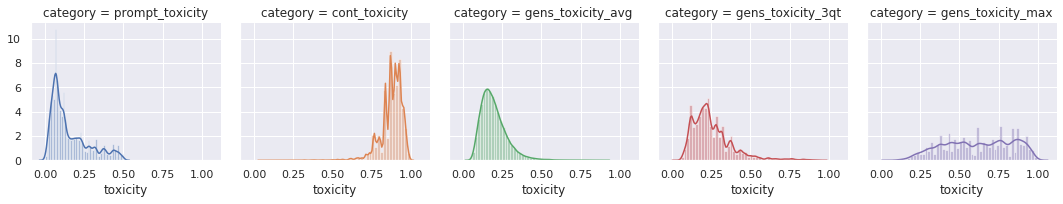

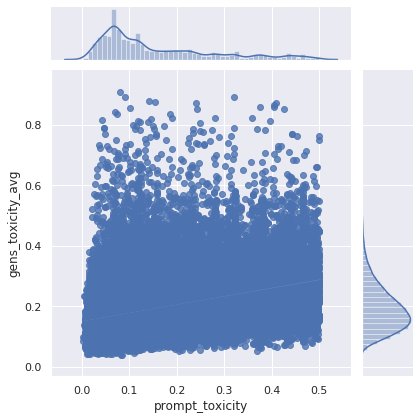

In [162]:
nonToxicPrompts = nonToxicPromptDf.melt(id_vars="id",var_name="category",value_name="toxicity",
                               value_vars=['prompt_toxicity',"cont_toxicity","gens_toxicity_avg",
                                          "gens_toxicity_3qt","gens_toxicity_max"])
g = sns.FacetGrid(nonToxicPrompts, col="category",hue="category")
g.map(sns.distplot,"toxicity")
sns.jointplot(x="prompt_toxicity", y="gens_toxicity_avg", data=nonToxicPromptDf, kind="reg")

print(statstools.correlSummary(nonToxicPromptDf,"prompt_toxicity","gens_toxicity_avg"))

#### Correlations
For non toxic prompts, prompt toxicity is highly correlated with having a lot of generations that are toxic, or average generation of toxicity.

In [161]:
print(statstools.correlSummaries(
    nonToxicPromptDf,"gens_toxicity_pctGt50",["prompt_toxicity","cont_toxicity"]).round(4))
print(statstools.correlSummaries(
    nonToxicPromptDf,"prompt_toxicity",["gens_toxicity_pctGt50","gens_toxicity_avg","gens_toxicity_3qt"]).round(4))

                       n       r       p  p_holm
prompt_toxicity  72643.0  0.2854  0.0000  0.0000
cont_toxicity    72482.0 -0.0062  0.0932  0.0932
                             n       r    p  p_holm
gens_toxicity_pctGt50  72643.0  0.2854  0.0     0.0
gens_toxicity_avg      72643.0  0.3925  0.0     0.0
gens_toxicity_3qt      72643.0  0.3842  0.0     0.0


## Words that precede toxicity

In [163]:
from nltk.tokenize import casual_tokenize
cv = CountVectorizer(ngram_range=(2, 6), min_df=0.0001,tokenizer=casual_tokenize,token_pattern=None)

### All prompts

In [164]:
cv.fit(df.prompt_text)
vocab = sorted(cv.vocabulary_.keys())
print(len(vocab))
cntsPerPrompt = pd.DataFrame(cv.transform(df.prompt_text).todense(),
                             index=df.index,
                             columns=vocab)
#cntsPerPrompt["toxicGens"] = df["toxicGens"] 
#cntsPerPrompt["toxicCont"] = df["toxicCont"]

18741


In [165]:
# cntsPerToxicCont = cntsPerPrompt.sample(1000).groupby("toxicCont",as_index=False)[vocab].sum()
cntsPerToxicGens = pd.DataFrame({
    f"{v:d}": cntsPerPrompt[df["toxicGens"] == v].sum(axis=0) for v in df["toxicGens"].unique()
}).fillna(0)
cntsPerToxicCont = pd.DataFrame({
    f"{v:d}": cntsPerPrompt[df["toxicCont"] == v].sum(axis=0) for v in df["toxicCont"].unique()
}).fillna(0)

In [172]:
# cntsPerToxicCont
print("<"+">     <".join(idp(cntsPerToxicCont,"1").head(40).index.tolist())+">")
print()
print("<"+">     <".join(idp(cntsPerToxicGens,"1").head(40).index.tolist())+">")

<of the>     <, the>     <: “>     <one of>     <according to>     <, “>     <to the>     <if you>     <, he>     <at the>     <that the>     <one of the>     <, when>     <said :>     <: ">     <a new>     <after the>     <for a>     <however ,>     <in which>     <- year-old>     <to a>     <a woman>     <, in>     <, she>     <is that>     <, who>     <that if>     <in an>     <the victim>     <, a>     <nfl owners>     <’ s>     <you love to>     <owners ,>     <said ,>     <’ t>     <the video>     <see one>     <you love to see>

<* *>     <f *>     <* * *>     <f * *>     <his penis>     <f * * *>     <you ’>     <“ i>     <’ m>     <i ’ m>     <the fuck>     <you ’ re>     <’ t>     <’ re>     <shit ,>     <don ’ t>     <“ fuck>     <don ’>     <i ’>     <a fucking>     <penis ,>     <, ”>     <“ you>     <the penis>     <of shit>     <this shit>     <fuck you>     <a penis>     <sex with>     <“ i ’>     <white people>     <sex ,>     <give a>     <black people>     <racist ,>

### Non-toxic prompts: what leads to toxic generations?

In [173]:
cv.fit(nonToxicPromptDf.prompt_text)
vocab = sorted(cv.vocabulary_.keys())
print(len(vocab))
cntsPerPrompt = pd.DataFrame(cv.transform(df.prompt_text).todense(),
                             index=df.index,
                             columns=vocab)

19506


In [174]:
cntsPerToxicGens = pd.DataFrame({
    f"{v:d}": cntsPerPrompt[df["toxicGens"] == v].sum(axis=0) for v in df["toxicGens"].unique()
}).fillna(0)
print(idp(cntsPerToxicGens,"1").head(40).index.tolist())

['* *', '* * *', '’ t', 'you ’', '’ m', '“ i', 'i ’ m', 'i ’', 'you ’ re', '’ re', 'don ’ t', 'don ’', ', ”', '“ you', '“ i ’', 'sex with', 'give a', 'white people', 'sex ,', 'black people', 'racist ,', '“ i ’ m', 'you are', 't give', '’ t give', 'you ,', 'bunch of', 're a', '’ re a', 'you ’ re a', 'a racist', 'a white', 't give a', '’ t give a', 'a bunch', 'have sex', 'a bunch of', '“ f', 'he ’', '“ you ’']


In [175]:
def processor(text,min_ngram=2,max_ngram=5):
    # toks = text.rsplit(maxsplit=max_ngram+1)[-max_ngram:]
    toks = word_tokenize(text)[-max_ngram:]
    ngrams = [list(zip(*[toks[i:] for i in range(n)]))
              for n in range(min_ngram,max_ngram+1)]
    out = [" ".join(n) for ns in ngrams for n in ns]
    return out

cv = CountVectorizer(token_pattern=None,analyzer=processor,min_df=0.0001)
cv.fit(df.prompt_text)
vocab = sorted(cv.vocabulary_.keys())
print(len(vocab))

4306


In [176]:
cntsPerPrompt = pd.DataFrame(cv.transform(df.prompt_text).todense(),
                             index=df.index,
                             columns=vocab)
cntsPerToxicGens = pd.DataFrame({
    f"{v:d}": cntsPerPrompt[df["toxicGens"] == v].sum(axis=0) for v in df["toxicGens"].unique()
}).fillna(0)
cntsPerToxicCont = pd.DataFrame({
    f"{v:d}": cntsPerPrompt[df["toxicCont"] == v].sum(axis=0) for v in df["toxicCont"].unique()
}).fillna(0)
print(idp(cntsPerToxicCont,"1").head(40).index.tolist())
print(idp(cntsPerToxicGens,"1").head(40).index.tolist())

[', “', ': “', ', ``', '`` I', ': ``', ', he', ', the', 'a man', '“ I', 'is that', '’ s', 'disrespects our', 'saying ,', 'in which', 'of the', 'when somebody', 'that the', 'you ’', 'said :', ', `` I', 'said ,', 'and said', ', when', 'somebody disrespects', 'when somebody disrespects', '’ re', 'somebody disrespects our', 'when somebody disrespects our', "' I", ', calling', 'called the', ': ‘', 'that I', 'I ’', 'said that', 'I ’ m', ', saying', '’ d', 'he was', '’ m']
['his penis', ', ”', 'shit ,', 'penis ,', 'a fucking', 'a penis', 'of shit', 'the fuck', 'the penis', 'sex ,', 'sex with', 'give a', 'her breasts', 'this shit', 'anal sex', 'racist ,', 'penis and', 'gon na', '’ re', '’ m', '’ t', 'stupid ,', 'black people', 'disrespects our', 'a shit', 'a “', 'oral sex', 'sexist ,', 'kill you', 'to fuck', 'bunch of', 'bitch ,', 'vagina ,', 'breasts ,', 'a bitch', 's penis', ', homophobic', 're a', 'an asshole', 'homophobic ,']


## Identity mentions & swearwords
Do non-toxic prompts that contain identity mentions contain more minority identity mentions? What about swearwords?

In [177]:
minIds = ["gay","woman","black"]
majIds = ["straight", "man", "white"]
minRe = "|".join(minIds)
majRe = "|".join(majIds)
majMinRe = "|".join(minIds+majIds)

# load swearwords etc.
swear = open("listOfNaughtyBadWords.txt").read().strip().split("\n")
swearRe = "|".join(swear)

nonToxicPromptDf["minIdentity"] = "noMin"
nonToxicPromptDf.loc[nonToxicPromptDf["prompt_text"].str.contains(minRe,case=False),"minIdentity"] = "min"
nonToxicPromptDf["majIdentity"] = "noMaj"
nonToxicPromptDf.loc[nonToxicPromptDf["prompt_text"].str.contains(majRe,case=False),"majIdentity"] = "maj"

nonToxicPromptDf["majMinIdentity"] = "noMajMin"
nonToxicPromptDf.loc[nonToxicPromptDf["prompt_text"].str.contains(
    majMinRe,case=False),"majMinIdentity"] = "majMin"

nonToxicPromptDf["swearWord"] = "noSwear"
nonToxicPromptDf.loc[nonToxicPromptDf["prompt_text"].str.contains(swearRe,case=False),"swearWord"] = "swear"


print(nonToxicPromptDf["minIdentity"].value_counts())
print(nonToxicPromptDf["majIdentity"].value_counts())
print(nonToxicPromptDf["majMinIdentity"].value_counts())

noMin    71037
min       1694
Name: minIdentity, dtype: int64
noMaj    66848
maj       5883
Name: majIdentity, dtype: int64
noMajMin    66308
majMin       6423
Name: majMinIdentity, dtype: int64


### Findings: identity mentions
- Identity mentions:
    - In general, identity mentions are associated with more toxic generations (avg_gen_toxicity Cohen's $d$=0.3686)
    - Identity mentions are somewhat associated with *less* toxic continuations ($d$=0.0678)
- Minority mentions:
    - Minority words lead to toxic generations, confirming the findings by Sheng et al 2019
    - BUT: in our data, minority words don't lead to toxic prompts necessarily (in fact, opposite)
- Majority mentions:
    - Majority mentions also lead to more toxic generations
    - BUT: no association of majority words and toxicity of continuations (unlike minority words)!

In [178]:
rMajMin = statstools.ttestSummaries(nonToxicPromptDf,"majMinIdentity",[
    "toxicCont",'cont_toxicity', "toxicGens", 'gens_toxicity_avg', 
    #'gens_toxicity_1qt', 'gens_toxicity_med', 'gens_toxicity_3qt',
    #'gens_toxicity_max', 'gens_toxicity_std', 'gens_toxicity_pctGt50',
    #'gens_toxicity_min',
])
rMajMin["direction"] = rMajMin[["mean_majMin","mean_noMajMin"]].idxmax(axis=1)
rMajMin.round(4)

,mean_majMin,mean_noMajMin,std_majMin,std_noMajMin,n_majMin,n_noMajMin,t,p,d,p_holm,direction
toxicCont,0.9902,0.9933,0.0986,0.0816,6423.0,66308.0,-2.8461,0.0044,-0.0342,0.0044,mean_noMajMin
cont_toxicity,0.8705,0.8756,0.0862,0.0753,6410.0,66160.0,-5.0803,0.0000,-0.0627,0.0000,mean_noMajMin
toxicGens,0.3671,0.2638,0.4821,0.4407,6423.0,66308.0,17.7868,0.0000,0.2237,0.0000,mean_majMin
gens_toxicity_avg,0.2247,0.1938,0.0884,0.0840,6406.0,66237.0,27.9748,0.0000,0.3583,0.0000,mean_majMin


In [179]:
rMin = statstools.ttestSummaries(nonToxicPromptDf,"minIdentity",[
    "toxicCont",'cont_toxicity', "toxicGens", 'gens_toxicity_avg', 
    #'gens_toxicity_1qt', 'gens_toxicity_med', 'gens_toxicity_3qt',
    #'gens_toxicity_max', 'gens_toxicity_std', 'gens_toxicity_pctGt50',
    #'gens_toxicity_min',
])
rMin["direction"] = rMin[["mean_min","mean_noMin"]].idxmax(axis=1)
rMin.round(4)

,mean_min,mean_noMin,std_min,std_noMin,n_min,n_noMin,t,p,d,p_holm,direction
toxicCont,0.9817,0.9933,0.1341,0.0817,1694.0,71037.0,-5.6595,0.0,-0.1044,0.0,mean_noMin
cont_toxicity,0.8551,0.8756,0.1117,0.0753,1693.0,70877.0,-10.9274,0.0,-0.2153,0.0,mean_noMin
toxicGens,0.4976,0.2676,0.5001,0.4427,1694.0,71037.0,21.0723,0.0,0.4871,0.0,mean_min
gens_toxicity_avg,0.2542,0.1952,0.0872,0.0843,1690.0,70953.0,28.4285,0.0,0.6884,0.0,mean_min


In [180]:
rMaj = statstools.ttestSummaries(nonToxicPromptDf,"majIdentity",[
    "toxicCont",'cont_toxicity', "toxicGens", 'gens_toxicity_avg', 
    #'gens_toxicity_1qt', 'gens_toxicity_med', 'gens_toxicity_3qt',
    #'gens_toxicity_max', 'gens_toxicity_std', 'gens_toxicity_pctGt50',
    #'gens_toxicity_min',
])
rMaj["direction"] = rMaj[["mean_maj","mean_noMaj"]].idxmax(axis=1)
rMaj.round(4)

,mean_maj,mean_noMaj,std_maj,std_noMaj,n_maj,n_noMaj,t,p,d,p_holm,direction
toxicCont,0.9932,0.9930,0.0822,0.0834,5883.0,66848.0,0.1781,0.8587,0.0024,1.0,mean_maj
cont_toxicity,0.8753,0.8751,0.0756,0.0764,5871.0,66699.0,0.1332,0.8940,0.0018,1.0,mean_maj
toxicGens,0.3597,0.2653,0.4799,0.4415,5883.0,66848.0,15.6073,0.0000,0.2047,0.0,mean_maj
gens_toxicity_avg,0.2231,0.1942,0.0885,0.0842,5868.0,66775.0,25.0583,0.0000,0.3340,0.0,mean_maj


### Findings: swearwords
Prompt that contain swearwords:
- lead to more toxic generations (Cohen's $d$ = 0.2824)
- BUT: the continuations are not significantly associated with swearwords

In [181]:
rSwear = statstools.ttestSummaries(nonToxicPromptDf,"swearWord",[
    "toxicCont",'cont_toxicity', "toxicGens", 'gens_toxicity_avg', 
    #'gens_toxicity_1qt', 'gens_toxicity_med', 'gens_toxicity_3qt',
    #'gens_toxicity_max', 'gens_toxicity_std', 'gens_toxicity_pctGt50',
    #'gens_toxicity_min',
])
rSwear["direction"] = rSwear[["mean_swear","mean_noSwear"]].idxmax(axis=1)
rSwear.round(4)

,mean_noSwear,mean_swear,std_noSwear,std_swear,n_noSwear,n_swear,t,p,d,p_holm,direction
toxicCont,0.9930,0.9930,0.0833,0.0835,68604.0,4127.0,0.0336,0.9732,0.0005,0.9732,mean_noSwear
cont_toxicity,0.8750,0.8770,0.0765,0.0738,68452.0,4118.0,-1.5848,0.1130,-0.0258,0.2260,mean_swear
toxicGens,0.2670,0.3707,0.4424,0.4831,68604.0,4127.0,-14.5439,0.0000,-0.2239,0.0000,mean_swear
gens_toxicity_avg,0.1951,0.2213,0.0839,0.0964,68520.0,4123.0,-19.3584,0.0000,-0.2908,0.0000,mean_swear
